<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 1
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

# Introducción

En el siguiente trabajo práctico, se propone abordar un problema real de ciencia de datos, investigar cada una de las etapas del proceso y resolverlo aplicando los contenidos desarrollados en clase.  
También, a partir de un conjunto de datos de reservas de hotel, proveídos por la cátedra, aplicar técnicas de análisis exploratorio, preprocesamiento de datos y entrenar un modelo de clasificación con el objetivo de predecir si una reserva será o no cancelada.

# Análisis Exploratorio y Preprocesamiento de Datos

## Exploración Inicial

### Carga inicial de dependencias y datos

En primer lugar, se cargan las dependencias a utilizar

In [358]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

y se cargan los datos de reserva de hoteles en el siguiente dataframe:

In [359]:
hotels_train_url = 'hotels_train.csv'
hotels_df = pd.read_csv(hotels_train_url)
hotels_df_backup = hotels_df.copy()

A continuación, se presentan las primeras 5 filas listadas con todas las respectivas columnas para tener una idea general de como se ven los datos para comenzar a analizarlos:

In [360]:
hotels_df.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,No Deposit,9.0,NaN,0,Transient,229.0,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,Non Refund,154.0,NaN,0,Transient,75.0,0,0,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,No Deposit,20.0,NaN,0,Transient-Party,75.0,0,1,28c75445-c603-413a-babf-ad377018b592,0


Hay un total de 31 columnas. De todos estos parámetros, se tendrán en cuenta aquellos que sirvan, en nuestro criterio, sean de utilidad para entrenar el modelo predictivo.  
Se propone analizar cada parámetro individualmente y, al finalizar, presentar un pequeño resumen con las conclusiones de este análisis inicial.

### Parámetros

#### hotel

El parámetro es un _string_ que indica el nombre del Hotel. En un principio, podría pensarse que resulta irrelevante para el entrenamiento del modelo propuesto en sí y respecto a su relación con el target, pero lo mejor es investigar un poco más. Podría llegar a suceder que un hotel tenga más cancelaciones que otro/s, y esto es un motivo a tener en cuenta. Sin embargo, si tuviese las reservas de un solo hotel, no sería necesario tenerlo en cuenta, puesto que solo trataría parámetros de ese hotel y sería un modelo predictivo para dicho hotel unicamente.

Se propone verificar la cantidad de valores únicos que aparecen en dicha columna:

In [361]:
hotel_unique = hotels_df['hotel'].unique()
hotel_unique_cant = len(hotel_unique)

print("La cantidad de hoteles cargados en el .CSV es de: ", hotel_unique_cant)
print()
print("Estos hoteles son: ", hotel_unique)

La cantidad de hoteles cargados en el .CSV es de:  2

Estos hoteles son:  ['City Hotel' 'Resort Hotel']


Entonces, se sabe que los datos obtenidos pertenecen a dos hoteles de nombres: "City Hotel" y "Resort Hotel".

Por otro lado, el parámetro es una **Variable Independiente Cualitativa de tipo Texto y es Nominal** ya que es una etiqueta (nombre del hotel) con valores no relacionados entre sí. Es, simplemente, una forma de identificar el establecimiento.  
Se propone obtener la cantidad de veces que aparecen ambos hoteles en las celdas y su frecuencia:

In [362]:
hotel_counts = hotels_df['hotel'].value_counts()
hotel_percentage = hotels_df['hotel'].value_counts(normalize=True)

print("La cantidad de veces que aparecen los hoteles son: ")
print(hotel_counts)
print()
print("Los porcentajes de aparición del nombre de los hoteles con respecto al total son: ")
print(hotel_percentage)

La cantidad de veces que aparecen los hoteles son: 
hotel
City Hotel      42129
Resort Hotel    19784
Name: count, dtype: int64

Los porcentajes de aparición del nombre de los hoteles con respecto al total son: 
hotel
City Hotel      0.680455
Resort Hotel    0.319545
Name: proportion, dtype: float64


Se puede observar que la mayoría de los registros provienen del _City Hotel_, siendo un poco menos del 70% del total.

Se presentan, a modo de visualización, dos **gráficos** con la cantidad de veces que aparece cada nombre:

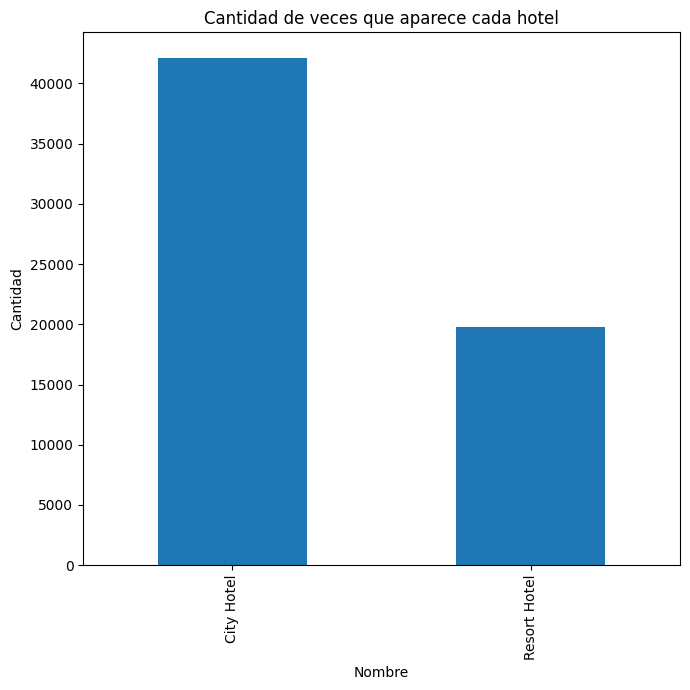

In [363]:
plt.figure(figsize=(7, 7))
hotel_counts.plot(kind='bar')
plt.xlabel('Nombre')
plt.ylabel('Cantidad')
plt.title('Cantidad de veces que aparece cada hotel')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

En forma de gráfico de torta:

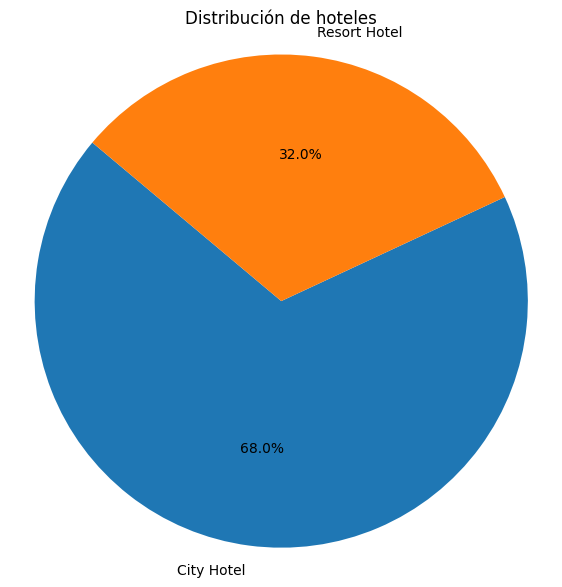

In [364]:
plt.figure(figsize=(7, 7))
plt.pie(hotel_counts, labels=hotel_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribución de hoteles')
plt.show()

Finalmente, se propone analizar la cantidad de cancelaciones según hotel:

In [365]:
city_hotel_df = hotels_df[hotels_df['hotel'] == "City Hotel"]
city_hotel_cancelations = city_hotel_df[city_hotel_df['is_canceled'] == 1]
city_hotel_cancelations_percentage = len(city_hotel_cancelations) / len(city_hotel_df)

resort_hotel_df = hotels_df[hotels_df['hotel'] == "Resort Hotel"]
resort_hotel_cancelations = resort_hotel_df[resort_hotel_df['is_canceled'] == 1]
resort_hotel_cancelations_percentage = len(resort_hotel_cancelations) / len(resort_hotel_df)

print("La cantidad de cancelaciones para el City Hotel es de: ", city_hotel_cancelations_percentage)
print()
print("La cantidad de cancelaciones para el Resort Hotel es de: ", resort_hotel_cancelations_percentage)

La cantidad de cancelaciones para el City Hotel es de:  0.5486007263405255

La cantidad de cancelaciones para el Resort Hotel es de:  0.3957238172260412


Se propone mostrar los resultados en dos gráficos de torta, uno por cada hotel:

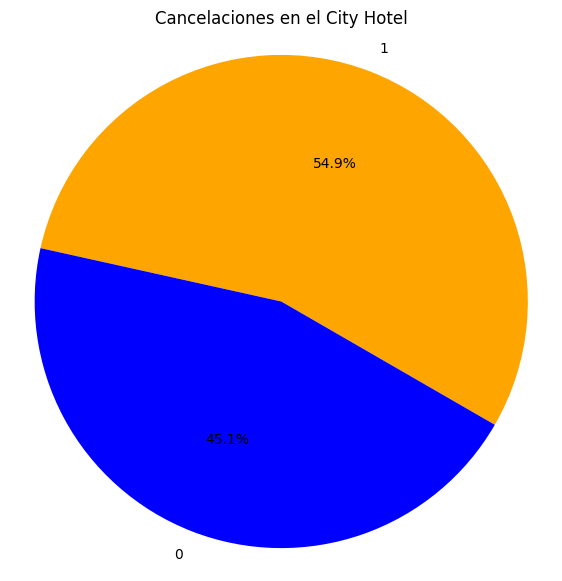

In [366]:
city_hotel_target_counts = city_hotel_df['is_canceled'].value_counts()

colores = ['orange', 'blue']

plt.figure(figsize=(7, 7))
plt.pie(city_hotel_target_counts, labels=city_hotel_target_counts.index, autopct='%1.1f%%', startangle=-30, colors=colores)
plt.axis('equal')
plt.title('Cancelaciones en el City Hotel')
plt.show()

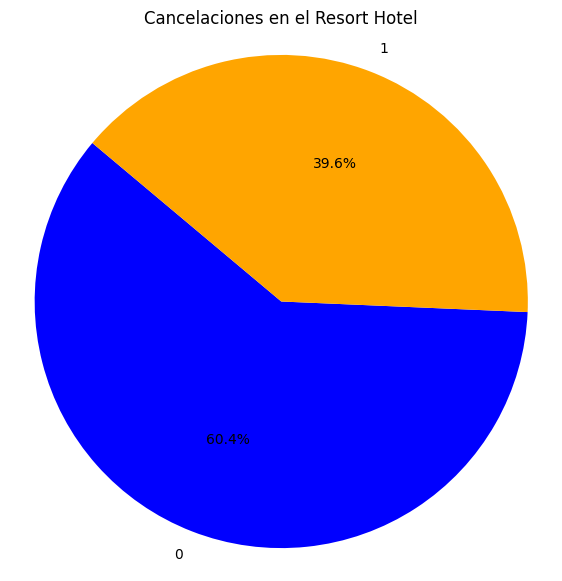

In [367]:
resort_hotel_target_counts = resort_hotel_df['is_canceled'].value_counts()

colores = ['blue', 'orange']

plt.figure(figsize=(7, 7))
plt.pie(resort_hotel_target_counts, labels=resort_hotel_target_counts.index, autopct='%1.1f%%', startangle=140, colors=colores)
plt.axis('equal')
plt.title('Cancelaciones en el Resort Hotel')
plt.show()

De esta manera, se puede observar que es más probable, un 15% más probable, que una reserva sea cancelada si proviene del _City Hotel_ que si lo hace del _Resort Hotel_. Por lo tanto, el parámetro _hotel_ es **relevante** y está relacionado con el **target**.  
No se pueden explicar las razones en principio, pero si se puede afirmar que es un parámetro relevante para el entrenamiento del modelo predictivo.

#### lead_time

El parámetro indica el número de días que transcurrieron entre la fecha de entrada de la reserva en el PMS y la fecha de ingreso del cliente al hotel. En principio, podría pensarse que aporta información relevante con respecto al target, pero es necesario investigar más.

El parámetro es un _integer_ de tipo **Variable Independiente Cuantitativa Discreta**, ya que es una medida discreta del tiempo y no se toman otros intervalos de tiempo. Se propone calcular la Media, la Mediana, la Varianza, la Desviación Estándar, la Moda, la Covarianza con respecto al Target y la Correlación de Pearson con respecto al Target.

In [399]:
parameter_column = hotels_df['lead_time'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

Media:  112.24818697204141
Mediana:  78.0
Varianza:  12258.267122558873
Desviación Estandar:  110.71705885977497
Moda:  0
Covarianza (con respecto a Target):  16.265487254459007
Correlación de Pearson (con respecto a Target):  0.2938160884261427


La **Media** indica el valor promedio obtenido, que teniendo en cuenta lo desarrollado anteriormente, puede aproximarse a 112 días.

La **Mediana** indica el valor que se encuentra en el centro de un conjunto de datos al estar ordenados en orden ascendente o descendente. En este caso, el valor obtenido es de 78 días, pero para decidir cual utilizar en caso de una corrección (si la Media o la Mediana), lo mejor es visualizar los datos en un gráfico y observar su distribución.

La **Varianza** indica cuán dispersos o agrupados están los valores en relación con la media (promedio) de los datos.

La **Desviación Estandar** se utiliza para cuantificar la dispersión o la variabilidad de un conjunto de datos. En este caso, el valor es muy grande, más de lo esperable, lo que llevaría a pensar que es posible que haya valores atípicos o que necesiten corrección.

La **Moda** representa el valor, o los valores, más frecuentes en el conjunto de datos. En este caso, el 0 podría indicar que la reserva se hizo el mismo día de llegada (osea no hubo reserva), o bien que no se tienen datos concretos para esa fila. Se debe realizar una investigación más profunda.

La **Covarianza** es positiva, significa que cuando una variable aumenta, la otra tiende a aumentar también. Si fuera negativa, sería el caso contrario y su fuese cero (o cercana a cero) no tendrian relación entre sí. Dado que la covarianza puede ser afectada por valores atípicos en los datos, esto puede hacer que sea difícil de interpretar. Por lo que se propone, analizar también la Correlación de Pearson.  

En el caso de la **Correlación de Pearson**, dado que es positiva, esto podría indicar que a medida que el tiempo entre la reserva y la fecha de llegada aumenta, la probabilidad de cancelación tiende a aumentar, lo que podría sugerir una relación positiva. Si fuese negativa esto indicaría una relación inversa y si fuese 0 no se observaría una relación lineal fuerte entre estas dos variables.
Dado que su relación, es más cercana a 0 que 1, pero positiva, se puede concluir que su relación no es completamente fuerte, pero se espera una mayor cancelación de la reserva a medida que pasa el tiempo.

Se propone continuar investigando mediante un gráfico de barras en el tiempo:

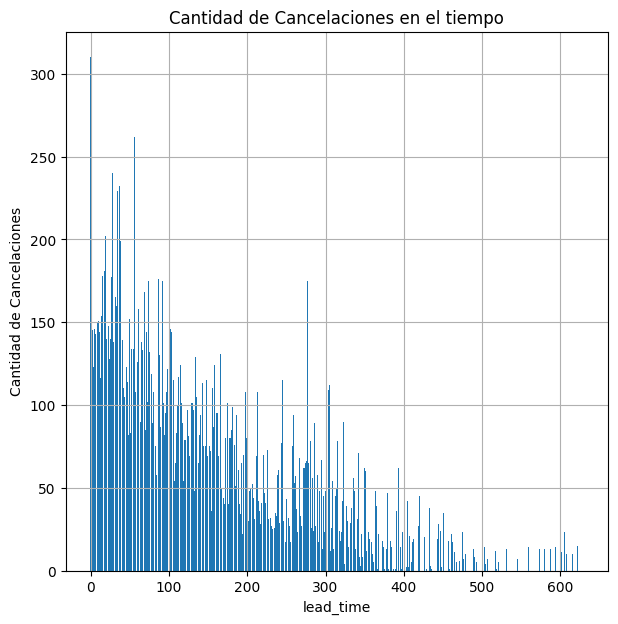

In [369]:
hotels_cancelations = hotels_df[hotels_df['is_canceled'] == 1]
hotels_cancelations_per_lead_time = hotels_cancelations['lead_time'].value_counts().sort_index()

plt.figure(figsize=(7, 7))
plt.bar(hotels_cancelations_per_lead_time.index, hotels_cancelations_per_lead_time.values)
plt.xlabel('lead_time')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cantidad de Cancelaciones en el tiempo')
plt.grid(True)
plt.show()

Del gráfico superior se deduce que la mayor cancelación de reservas ocurre en los primeros 100 días y luego comienza a descender, aunque tiene sentido también porque menos gente reserva con tanto tiempo de antelación. Para verificar el porcentaje de cancelaciones con respecto al tiempo, se propone dividir el *lead_time* en intervalos de 30 días (aproximadamente 1 mes).

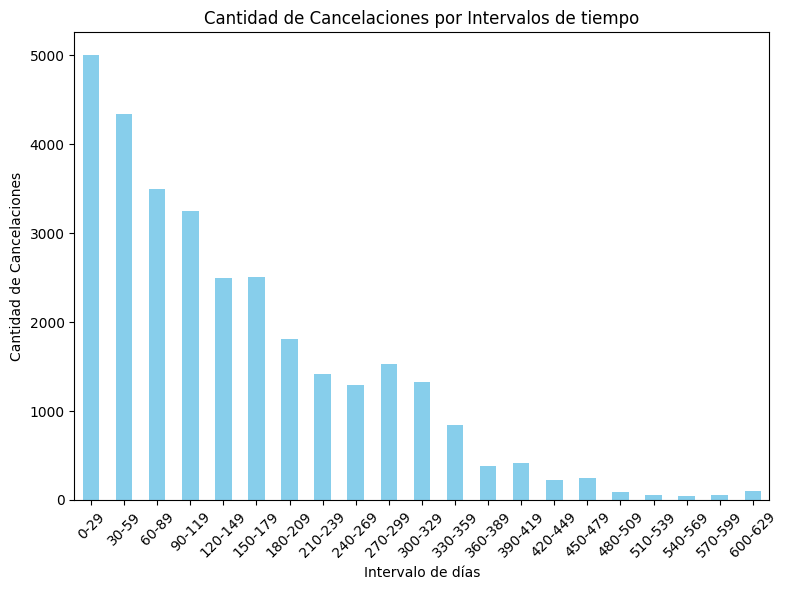

In [370]:
hotels_lead_time_cancel_intervals = list(range(0, max(hotels_cancelations["lead_time"].tolist()) + 31, 30))
hotels_lead_time_cancel_labels = [f'{i}-{i+29}' for i in hotels_lead_time_cancel_intervals[:-1]]
hotels_cancelations_per_lead_time_intervalos = pd.cut(hotels_cancelations_per_lead_time.index, bins=hotels_lead_time_cancel_intervals, labels=hotels_lead_time_cancel_labels, include_lowest=True)
hotel_cancelations_per_interval = hotels_cancelations_per_lead_time.groupby(hotels_cancelations_per_lead_time_intervalos, observed=False).sum()

plt.figure(figsize=(8, 6))
hotel_cancelations_per_interval.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Cancelaciones por Intervalos de tiempo')
plt.xlabel('Intervalo de días')
plt.ylabel('Cantidad de Cancelaciones')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

Este gráfico es más claro que el anterior incluso, ya que toma períodos de tiempo. Para poder comparar si realmente es relevante la variable, se propone ahora tomar porcentajes por intervalos.

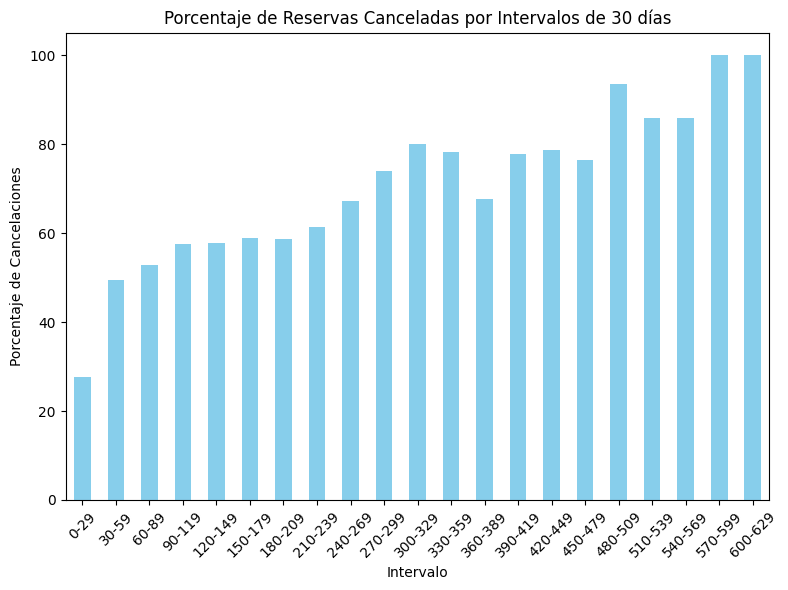

In [371]:
hotels_df['lead_time_intervals'] = pd.cut(hotels_df['lead_time'], bins=hotels_lead_time_cancel_intervals, labels=hotels_lead_time_cancel_labels, include_lowest=True)
reservas_por_intervalo = hotels_df['lead_time_intervals'].value_counts().sort_index()
cancelaciones_por_intervalo = hotels_df[hotels_df['is_canceled'] == 1]['lead_time_intervals'].value_counts().sort_index()
porcentajes_cancelaciones = (cancelaciones_por_intervalo / reservas_por_intervalo) * 100

plt.figure(figsize=(8, 6))
porcentajes_cancelaciones.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Intervalos de 30 días')
plt.xlabel('Intervalo')
plt.ylabel('Porcentaje de Cancelaciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# regreso hotels_df a su estado original
hotels_df = hotels_df_backup

Como puede observarse, con una reserva de menos de 30 días las probabilidades de que dicha reserva sea cancelada son mucho menores a las de mayor tiempo. A partir de los 2 meses las probabilidades superan el 50% y a medida que pasa el tiempo es aún más probable. Incluso a partir de los 570 días ya es una 100% de probabilidad de que dicha reserva sea cancelada.

Esto significa que *lead_time* es un parámetro **relevante** para el entrenamiento del modelo y, además, que está relacionado con **target**.  
Por otro lado, también es un indicador de que cuanto más tiempo pase, más probable será que la reserva sea cancelada.

#### arrival_date_year

El parámetro describe el año de arribo. En sí, no es un parámetro relevante para predecir futuras cancelaciones de reservas. Es un dato que puede resultar útil para estudiar porque hubo un aumento o disminución de reservas, por ejemplo por alguna crisis mundial económica; pero más allá de eso, no servirá para entrenar el modelo. Aunque podría utilizarse, para predecir las cancelaciones en esos años en concreto, pero la idea sería poder utilizar el modelo en el futuro en los próximos años, por lo que es **irrelevante** y su relación con el **target** ayuda a explicar hechos pasados, pero no necesariamente futuros en este caso puntual.

Por otro lado, es una **Variable Independiente Cuantitativa Discreta**, ya que es un intervalo de tiempo discretizado. Se propone calcular la Media, la Mediana, la Varianza, la Desviación Estándar, la Moda, la Covarianza con respecto al Target y la Correlación de Pearson con respecto al Target.

In [398]:
parameter_column = hotels_df['arrival_date_year'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

Media:  2016.1547494064253
Mediana:  2016.0
Varianza:  0.5018065016562059
Desviación Estandar:  0.7083830190343399
Moda:  2016
Covarianza (con respecto a Target):  0.007056767925435907
Correlación de Pearson (con respecto a Target):  0.019923274956089875


La mayoría de las reservas ocurrieron en el 2016, los años poseen una desviación estandar chica. Además, la covarianza y la correlación de Pearson revelan un valor muy cercano a 0, por lo que no guardan una relación fuerte con el **Target**.

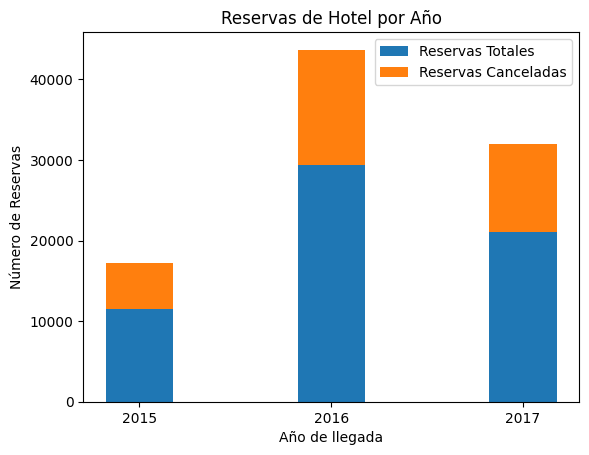

In [373]:
total_reservas_per_year = hotels_df.groupby('arrival_date_year')['is_canceled'].count()
reservas_canceladas_per_year = hotels_df[hotels_df['is_canceled'] == 1].groupby('arrival_date_year')['is_canceled'].count()
years = total_reservas_per_year.index
fig, ax = plt.subplots()
ancho_barra = 0.35
barra_total = ax.bar(years, total_reservas_per_year, width=ancho_barra, label='Reservas Totales')
barra_cancelada = ax.bar(years, reservas_canceladas_per_year, width=ancho_barra, label='Reservas Canceladas', bottom=total_reservas_per_year)


ax.set_xlabel('Año de llegada')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas de Hotel por Año')
ax.set_xticks(years)
ax.legend()
plt.show()

Si bien se puede observar que la mayor cantidad de reservas provienen del año 2016, el porcentaje de reservas/cancelaciones parecería ser el mismo. A continuación, se puede verificar esto:

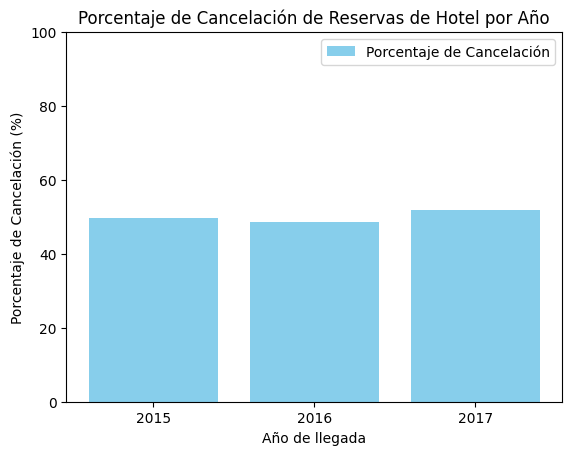

In [374]:
cancelations_perc_per_year = (hotels_df.groupby('arrival_date_year')['is_canceled'].mean() * 100).round(2)

years = cancelations_perc_per_year.index
fig, ax = plt.subplots()
ax.bar(years, cancelations_perc_per_year, color='skyblue', label='Porcentaje de Cancelación')
ax.set_ylim(0, 100)

ax.set_xlabel('Año de llegada')
ax.set_ylabel('Porcentaje de Cancelación (%)')
ax.set_title('Porcentaje de Cancelación de Reservas de Hotel por Año')
ax.set_xticks(years)
ax.legend()

plt.show()

Como puede observarse, el porcentaje de cancelación de reservas se mantiene aproximadamente constante.

#### arrival_date_month

De forma similar al anterior, este parámetro podría decirse que continúa con la misma línea de pensamiento, pero es necesario investigar para estar seguros, ya que podría suceder que haya más cancelaciones según la época del año.

Es una **Variable Independiente Cualitativa Texto Nominal** debido a que es una etiqueta no relacionada, que solamente indica el mes.

A continuación, se presentan el mes con mayor cantidad de reservas y el que posee mayor cantidad de cancelaciones:

In [375]:
arrival_date_month_more_reservations =  hotels_df['arrival_date_month'].mode().iloc[0]
arrival_date_month_more_cancelations =  hotels_df[hotels_df["is_canceled"] == 1]['arrival_date_month'].mode().iloc[0]

print("Mes con mayor cantidad de reservas: ", arrival_date_month_more_reservations)
print("Mes con mayor cantidad de cancelaciones: ", arrival_date_month_more_cancelations)


Mes con mayor cantidad de reservas:  August
Mes con mayor cantidad de cancelaciones:  August


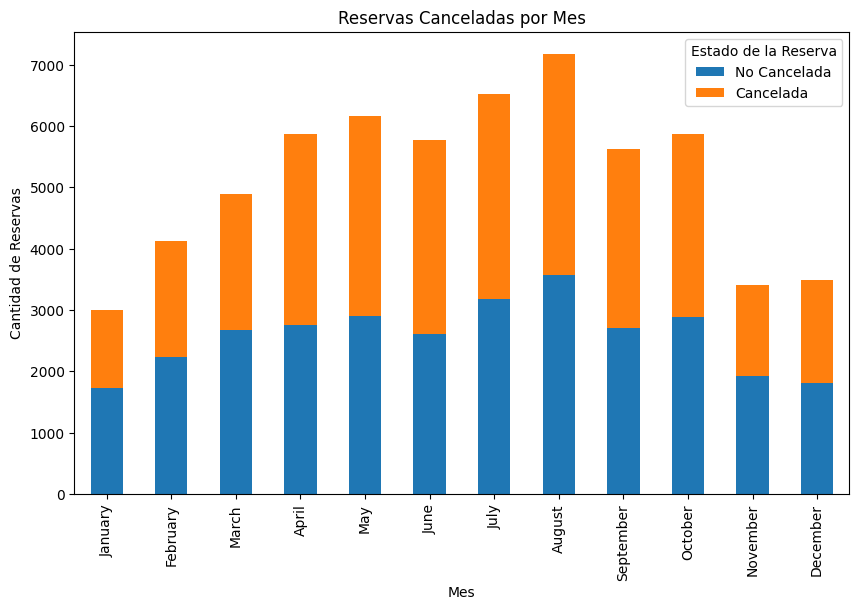

In [376]:
monthly_cancelations = hotels_df.groupby(['arrival_date_month', 'is_canceled']).size().unstack()
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_cancelations = monthly_cancelations.reindex(ordered_months)

ax = monthly_cancelations.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Reservas Canceladas por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Reservas')
plt.legend(['No Cancelada', 'Cancelada'], title='Estado de la Reserva')

plt.show()

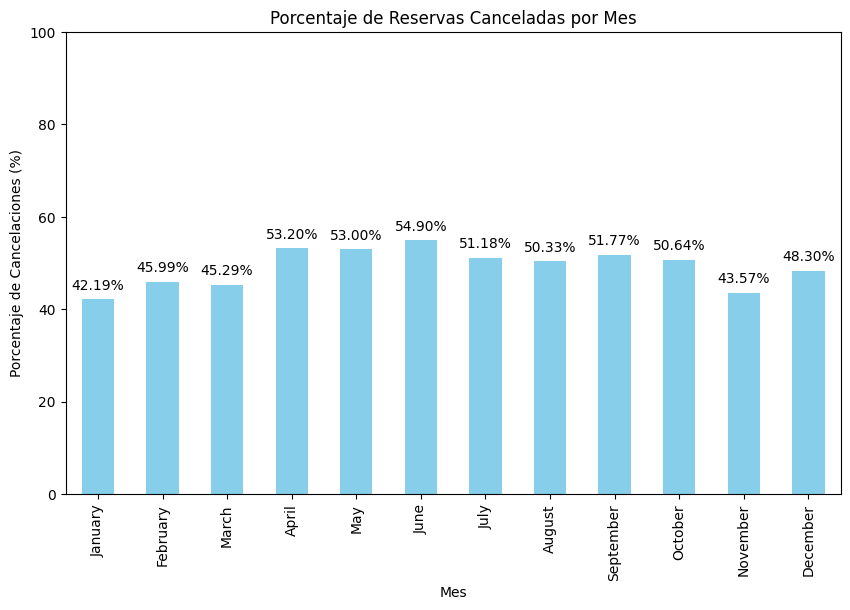

In [377]:
monthly_totals = hotels_df.groupby('arrival_date_month').size()
monthly_cancelations = hotels_df[hotels_df['is_canceled'] == 1].groupby('arrival_date_month').size()
monthly_cancelation_percentage = (monthly_cancelations / monthly_totals) * 100
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_cancelation_percentage = monthly_cancelation_percentage.reindex(ordered_months)

max_percentage = monthly_cancelation_percentage.max()

ax = monthly_cancelation_percentage.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Mes')
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Cancelaciones (%)')
plt.ylim(0, 100)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()

Como puede observarse en el gráfico superior, hay mayor cantidad de cancelaciones en Junio que en Enero, por lo que es un parámetro **relevante** a la hora de entrenar el modelo y se debe destacar que mantiene una relación con respecto al **target**.

#### arrival_date_week_number

Este parámetro en principio no parece tener una relevancia demasiado grande, ya que con el parámetro *lead_time* se tiene una buena aproximación de la cantidad de días previos al arribo pasaron. De todas maneras, se propone investigar, teniendo en cuenta que es una **Variable Independiente Cuantitativa Discreta**, puesto que es una discretización del tiempo. 

Entonces, se propone mostrar las medidas de resumen:

In [397]:
parameter_column = hotels_df['arrival_date_week_number'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

Media:  27.21808020932599
Mediana:  28.0
Varianza:  182.95000211609326
Desviación Estandar:  13.525901157264652
Moda:  33
Covarianza (con respecto a Target):  0.05652184137557416
Correlación de Pearson (con respecto a Target):  0.008357437316708986


Observando la Covarianza y la Correlación de Pearson, con sus valores cercanos a 0, ya comienza a dar una idea de que no es un parámetro a tener en cuenta.

Finalmente, se vuelcan los resultados en un gráfico de barras con porcentajes de cancelaciones por intervalo de 4 semanas.

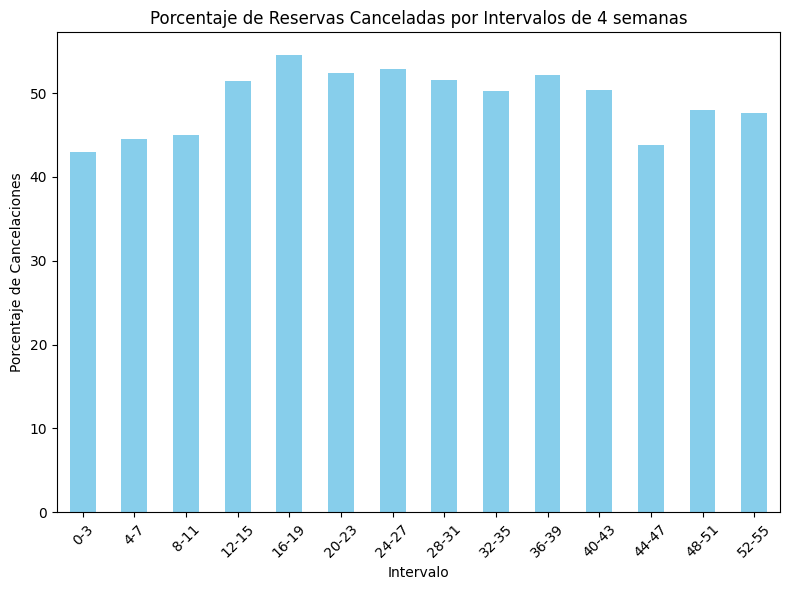

In [379]:
hotels_adwn_cancel_intervals = list(range(0, max(hotels_cancelations["arrival_date_week_number"].tolist()) + 5, 4))
hotels_adwn_cancel_labels = [f'{i}-{i+3}' for i in hotels_adwn_cancel_intervals[:-1]]

hotels_df['adwn_intervals'] = pd.cut(hotels_df['arrival_date_week_number'], bins=hotels_adwn_cancel_intervals, labels=hotels_adwn_cancel_labels, include_lowest=True)
reservas_por_intervalo = hotels_df['adwn_intervals'].value_counts().sort_index()
cancelaciones_por_intervalo = hotels_df[hotels_df['is_canceled'] == 1]['adwn_intervals'].value_counts().sort_index()
porcentajes_cancelaciones = (cancelaciones_por_intervalo / reservas_por_intervalo) * 100

plt.figure(figsize=(8, 6))
porcentajes_cancelaciones.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Reservas Canceladas por Intervalos de 4 semanas')
plt.xlabel('Intervalo')
plt.ylabel('Porcentaje de Cancelaciones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# regreso hotels_df a su estado original
hotels_df = hotels_df_backup

Como puede observarse, no hay una diferencia particularmente apreciable, aunque hay fluctuaciones. Hay menos cancelaciones a menor cantidad de semanas, pero también se había llegado a esta conclusión con *lead_time*, por lo que no parece que sea una variable **relevante** para el entrenamiento del modelo, aunque si guarda una relación con el **target**. 

#### arrival_date_day_of_month

En un principio, podría pensarse que continúa la misma línea de pensamiento que el parámetro anterior, pero lo mejor es investigar más ya que podría suceder que cambie según si es el comienzo, la mitad o el final del mes. Es una **Variable Independiente Cuantitativa Discreta**, ya que es una variable de tiempo discretizada.

Se propone calcular las medidas de resumen:

In [380]:
parameter_column = hotels_df['arrival_date_day_of_month'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

Media:  15.785812349587324
Mediana:  16.0
Varianza:  77.35936972151046
Desviación Estandar:  8.79541754105571
Moda:  17
Covarianza (con respecto a Target):  -0.03241407010888681
Correlación de Pearson (con respecto a Target):  -0.007370554150145503


A partir de los datos proporcionados, no parece que haya una relación clara, incluso la Correlación de Pearson dió negativa y cercana a 0, lo que significaría que no hay una relación estrecha con la variable **Target**.

Se propone mostrar esto en un gráfico de tipo Histograma:

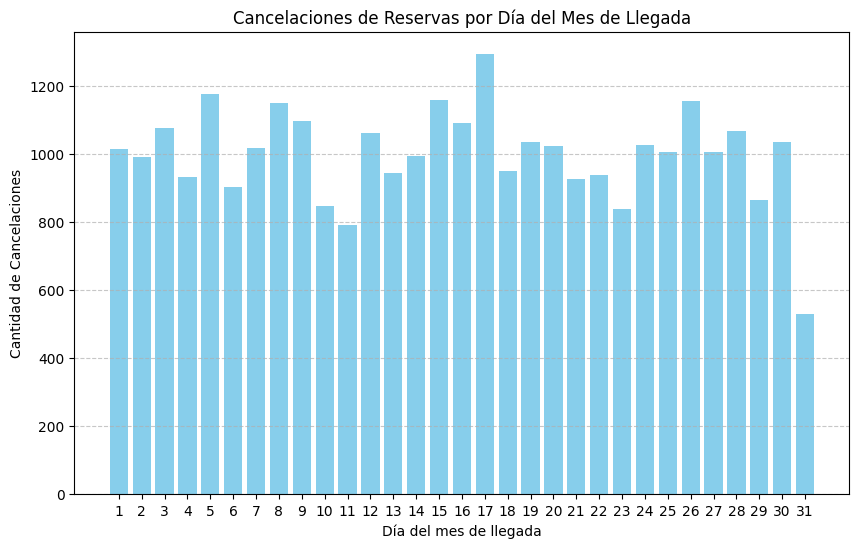

In [381]:
cancelations_by_day = hotels_cancelations['arrival_date_day_of_month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(cancelations_by_day.index, cancelations_by_day.values, color='skyblue')
plt.xlabel('Día del mes de llegada')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cancelaciones de Reservas por Día del Mes de Llegada')
plt.xticks(range(1, 32)) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Se propone mostrar ahora con porcentajes:

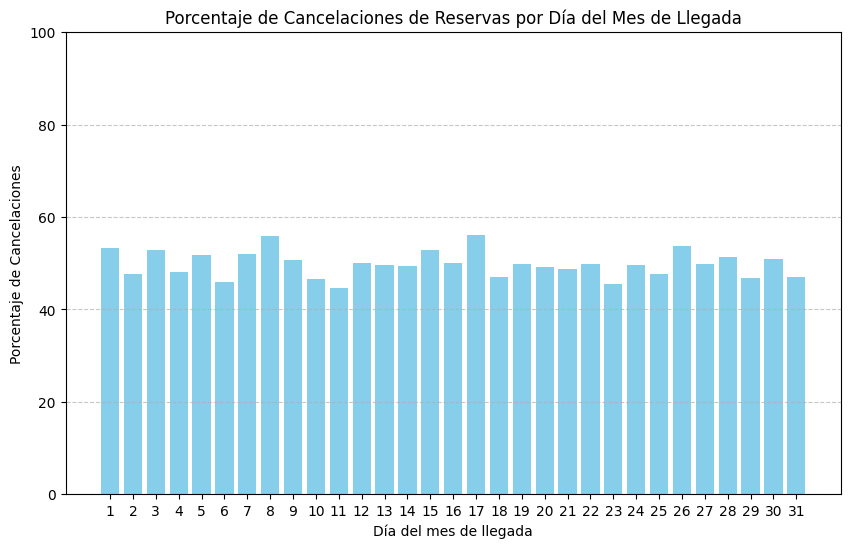

In [382]:
total_reservations_by_day = hotels_df['arrival_date_day_of_month'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_day = cancelled_reservations['arrival_date_day_of_month'].value_counts().sort_index()

percentages = (cancelations_by_day / total_reservations_by_day) * 100

plt.figure(figsize=(10, 6))
plt.bar(percentages.index, percentages.values, color='skyblue')
plt.xlabel('Día del mes de llegada')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas por Día del Mes de Llegada')
plt.xticks(range(1, 32))
plt.ylim(0, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ahora, es aún más claro que el porcentaje no cambia en el tiempo. Por lo que se puede concluir que este parámetro es **irrelevante** para el entrenamiento del modelo y no guarda una relación estrecha con el **target**

#### stays_in_weekend_nights

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, ya que es una discretización del tiempo. Se propone, tal y como antes, las medidas de resumen: 

In [383]:
parameter_column = hotels_df['stays_in_weekend_nights'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

Media:  0.9241354804322194
Mediana:  1.0
Varianza:  0.986233333089822
Desviación Estandar:  0.9930928119213339
Moda:  0
Covarianza (con respecto a Target):  0.0006351611956761096
Correlación de Pearson (con respecto a Target):  0.0012791372744576411


No parece que haya un relación clara con respecto al **Target**, pero se propone graficar el total de reservas canceladas según la cantidad de noches de fin de semana y el porcentaje de cancelaciones para cada valor posible:

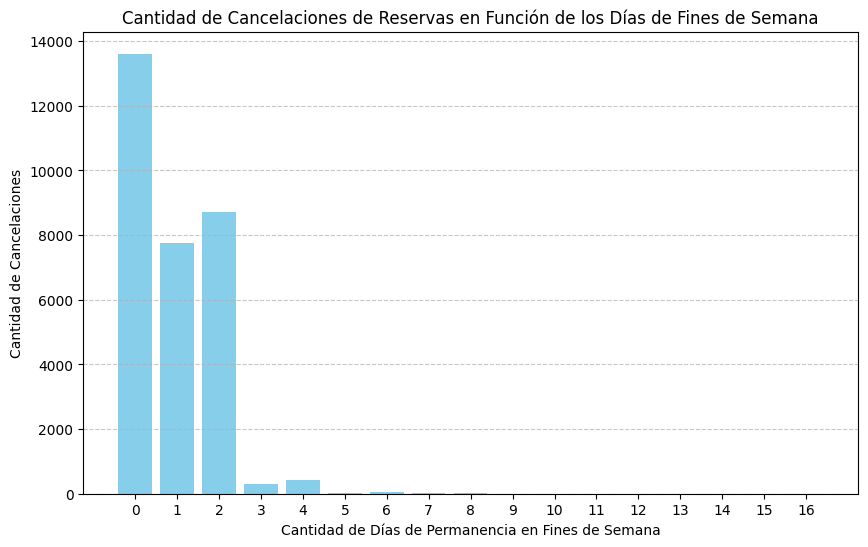

In [384]:
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_weekend_nights = cancelled_reservations['stays_in_weekend_nights'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(cancelations_by_weekend_nights.index, cancelations_by_weekend_nights.values, color='skyblue')
plt.xlabel('Cantidad de Días de Permanencia en Fines de Semana')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cantidad de Cancelaciones de Reservas en Función de los Días de Fines de Semana')
plt.xticks(range(max(cancelations_by_weekend_nights.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como se puede observar, la mayoría de la gente no reserva más de noches de fin de semana, por lo que esto se debe tener en cuenta a la hora de decidir si vale la pena tener en cuenta este parámetro. Para el caso de los porcentajes:

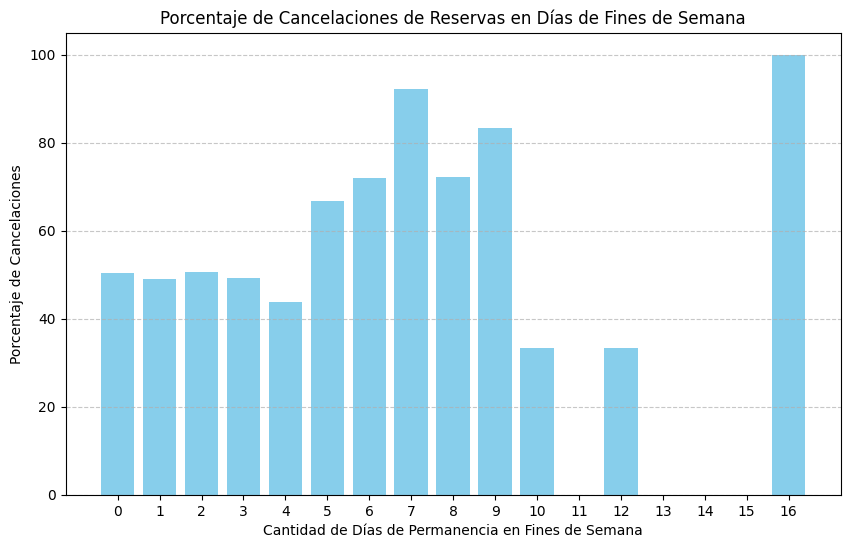

In [385]:
total_reservations_by_weekend_nights = hotels_df['stays_in_weekend_nights'].value_counts().sort_index()
percentages = (cancelations_by_weekend_nights / total_reservations_by_weekend_nights) * 100

plt.figure(figsize=(10, 6))
plt.bar(percentages.index, percentages.values, color='skyblue')
plt.xlabel('Cantidad de Días de Permanencia en Fines de Semana')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas en Días de Fines de Semana')
plt.xticks(range(max(percentages.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podría pensarse que hay una variación muy grande, pero la realidad es que en comparación más de 4 noches de fin de semana ya no importan realmente en comparación con los demás.

Por lo que, para finalizar, el **Target** no tiene una relación tan fuerte con esta variable, y se puede considerar **irrelevante** para el entrenamiento del modelo.

#### stays_in_week_nights

Este parámetro es una **Variable Independiente Cuantitativa Discreta**, ya que es una discretización del tiempo. En principio, podría pensarse que continúa con la misma lógica del parámetro anterior, por esto se propone investigar un poco más. Tal y como se hizo antes, se presentan las medidas de resumen: 

In [386]:
parameter_column = hotels_df['stays_in_week_nights'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

Media:  2.5100544312179993
Mediana:  2.0
Varianza:  3.5528885874786686
Desviación Estandar:  1.884910763797233
Moda:  2
Covarianza (con respecto a Target):  0.026802652857020933
Correlación de Pearson (con respecto a Target):  0.028438718504006387


En principio, no parecería tener una relación tan fuerte con el **Target**.

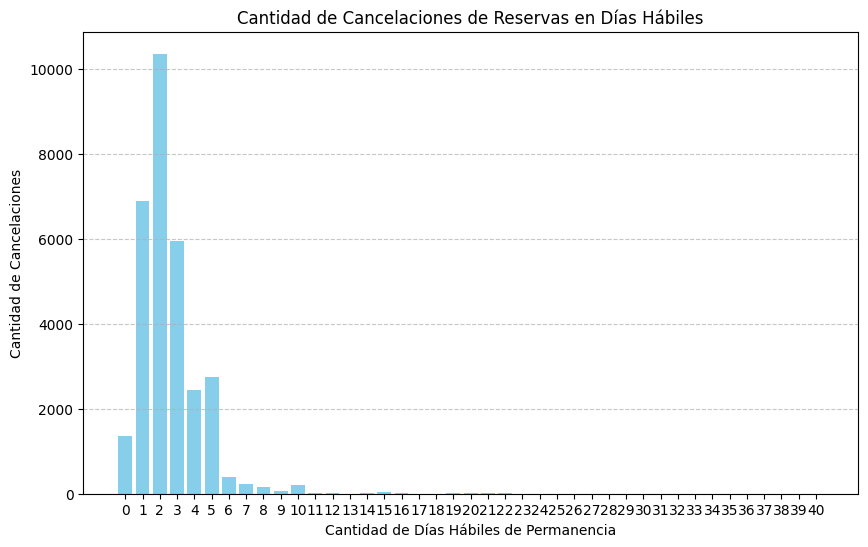

In [387]:
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_week_nights = cancelled_reservations['stays_in_week_nights'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(cancelations_by_week_nights.index, cancelations_by_week_nights.values, color='skyblue')
plt.xlabel('Cantidad de Días Hábiles de Permanencia')
plt.ylabel('Cantidad de Cancelaciones')
plt.title('Cantidad de Cancelaciones de Reservas en Días Hábiles')
plt.xticks(range(max(cancelations_by_week_nights.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como puede observarse, la mayor cantidad de datos importan hasta aproximadamente el día 10, luego son realmente muy pocos los datos que se tienen en comparación. Se propone ahora mostrar por porcentajes:

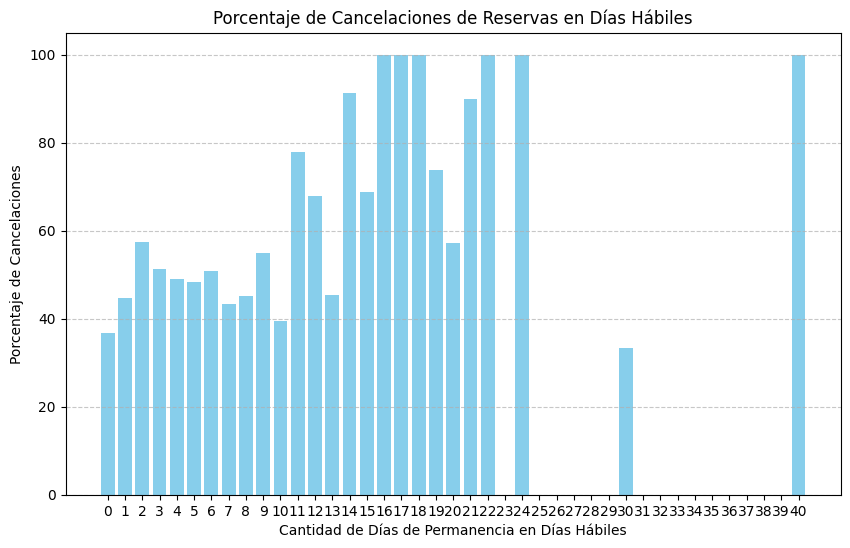

In [388]:
total_reservations_by_week_nights = hotels_df['stays_in_week_nights'].value_counts().sort_index()
percentages = (cancelations_by_week_nights / total_reservations_by_week_nights) * 100

plt.figure(figsize=(10, 6))
plt.bar(percentages.index, percentages.values, color='skyblue')
plt.xlabel('Cantidad de Días de Permanencia en Días Hábiles')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas en Días Hábiles')
plt.xticks(range(max(percentages.index) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Hasta el día 10 no se ve un cambio demasiado profundo, pero a partir de ese día ya el cambio es mayor. Dado que no se tienen una cantidad de datos comparables a partir de dicha cantidad de días, es **irrelevante** considerar esta variable, aunque vale la pena aclarar que sí tiene una relación con el **Target**, lo que sucede es que resulta lo mejor despreciarla ya que no se tienen tantas reservas a partir del día 10.

#### adults

El número de adultos podría llegar a ser una variable relevante, teniendo en cuenta que a mayor cantidad de adultos, resulta más dificil planificar un viaje y esto podría llevar a que se cancele la reserva.

 Este parámetro es una **Variable Independiente Cuantitativa Discreta**, por lo que se propone calcular las medidas de resumen:

In [389]:
parameter_column = hotels_df['adults'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

Media:  1.862791336229871
Mediana:  2.0
Varianza:  0.34699356195423825
Desviación Estandar:  0.589061594363644
Moda:  2
Covarianza (con respecto a Target):  0.017724726478090883
Correlación de Pearson (con respecto a Target):  0.060178570747318826


En general el promedio es de 2 personas adultas, por lo que la mayor cantidad de reservas probablemente se den para parejas. Tampoco se ve que haya una relación tan fuerte con el **Target**. Se propone mostrar un gráfico de barras para observar la cantidad de reservas en función de la cantidad de adultos:

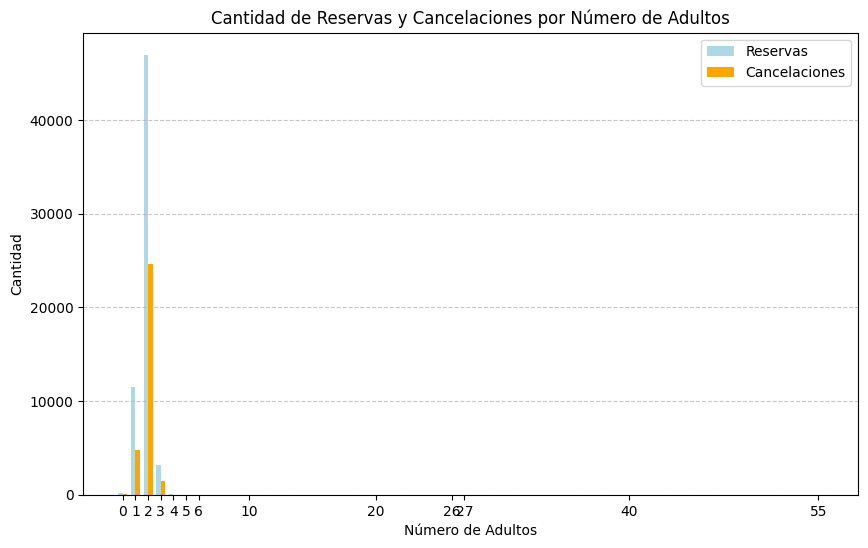

In [390]:
reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = reservations_by_adults.index

plt.bar(index, reservations_by_adults, bar_width, label='Reservas', color='lightblue')
plt.bar(index + bar_width, cancelations_by_adults, bar_width, label='Cancelaciones', color='orange')
plt.xlabel('Número de Adultos')
plt.ylabel('Cantidad')
plt.title('Cantidad de Reservas y Cancelaciones por Número de Adultos')
plt.xticks(index + bar_width / 2, index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como se puede observar, hasta más de 4 adultos parece despreciable la estadística. Incluso se podría llegar a pensar que hay algunos valores atípicos, outliers, dado que resulta bastante extraño pensar en una reserva para 55 adultos salvo que sea un viaje de excursión o algo del estilo. Se propone limitar el gráfico hasta 6 adultos para poder verlo mejor.

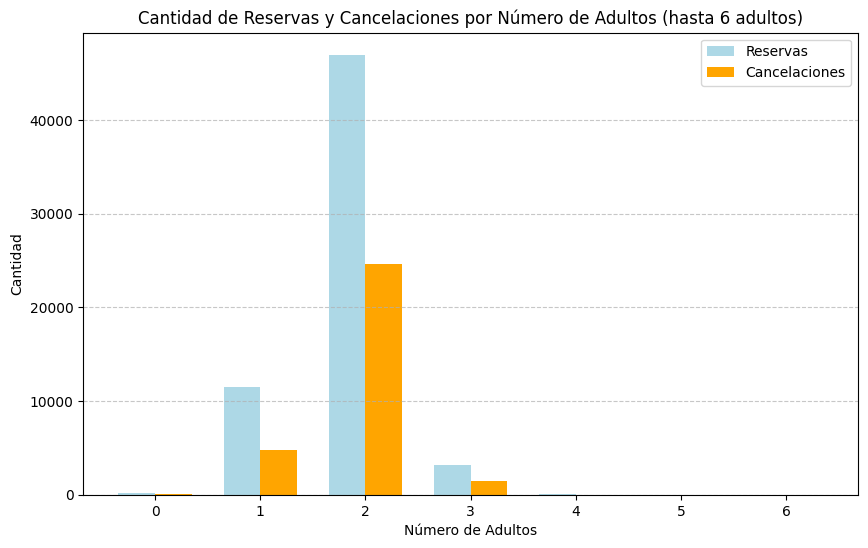

In [391]:
hotels_df['adults'] = hotels_df['adults'].clip(upper=6)
reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = reservations_by_adults.index

plt.bar(index, reservations_by_adults, bar_width, label='Reservas', color='lightblue')
plt.bar(index + bar_width, cancelations_by_adults, bar_width, label='Cancelaciones', color='orange')
plt.xlabel('Número de Adultos')
plt.ylabel('Cantidad')
plt.title('Cantidad de Reservas y Cancelaciones por Número de Adultos (hasta 6 adultos)')
plt.xticks(index + bar_width / 2, index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ahora los números son más claros y parece que la mayor cantidad de reservas/cancelaciones se encuentran hasta 3 adultos. Incluso se ve que hay un pequeño porcentaje de 0 adultos, lo cual también parece extraño y podrían ser valores atípicos que deberán ser estudiados más adelante. Para poder comparar mejor, se muestran ahora con porcentajes:

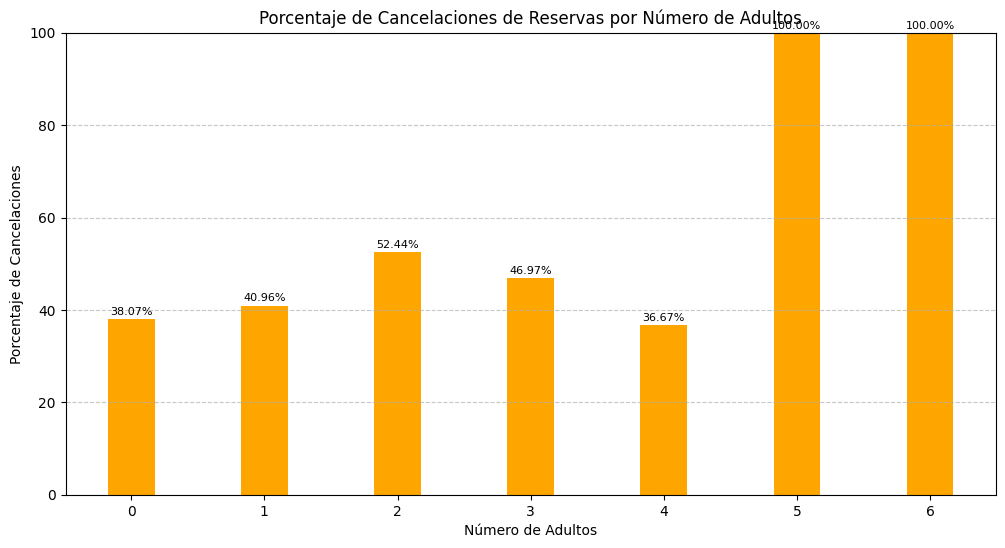

In [392]:
total_reservations_by_adults = hotels_df['adults'].value_counts().sort_index()
cancelled_reservations = hotels_df[hotels_df['is_canceled'] == 1]
cancelations_by_adults = cancelled_reservations['adults'].value_counts().sort_index()
percentages = (cancelations_by_adults / total_reservations_by_adults) * 100

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = percentages.index
bars = plt.bar(index, percentages.values, bar_width, color='orange')
plt.xlabel('Número de Adultos')
plt.ylabel('Porcentaje de Cancelaciones')
plt.title('Porcentaje de Cancelaciones de Reservas por Número de Adultos')
plt.xticks(index)
plt.ylim(0, 100)

for bar, percentage in zip(bars, percentages.values):
    plt.annotate(f'{percentage:.2f}%', 
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 3),
                 textcoords='offset points',
                 ha='center',
                 fontsize=8,
                 color='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Al observar detenidamente, se puede apreciar que hay una diferencia de un 10% en las cancelaciones al aumentar el número de adultos de 1 a 2, y un valor intermedio al ser 3, pero sigue siendo mayor que 1, aunque no por mucho. Esto seguramente se deba a que es más dificil acordar con más personas que viajar solo. Es tan así, que para 5 y 6 personas el porcentaje de cancelación alcanza el 100%.

Se concluye que es **relevante** para el entrenamiento del modelo y que guarda una relación con el **Target**.

#### children

En cuanto a análisis, este parámetro resulta similar al de _adults_, pero es una variable dependiente, ya que los niños no deberían poder viajar solos y mucho menos quedarse en un hotel sin permiso de sus padres. En este caso es una **Variable Dependiente Cuantitativa Discreta**.

Se propone, al igual que en otras ocasiones, tomar medidas de resumen:

In [393]:
# Dado que hay muchos NaN, se propone reemplazarlos con 0 para obtener las medidas de resumen, ya que si no los resultados arrojan NaN
hotels_df['babies'].fillna(0, inplace=True)

parameter_column = hotels_df['children'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

hotels_df = hotels_df_backup

Media:  nan
Mediana:  nan
Varianza:  nan
Desviación Estandar:  nan
Moda:  0.0
Covarianza (con respecto a Target):  nan
Correlación de Pearson (con respecto a Target):  nan


Por lo general, los adultos viajan sin hijos. Vale aclarar que se reemplazaron los valores NaN con 0, ya que si no arrojaban resultados NaN. No parece haber una relación muy fuerte con respecto a Target.

Se propone mostrar en un gráfico de torta, los porcentajes de cancelación de personas con hijos y de personas sin hijos.

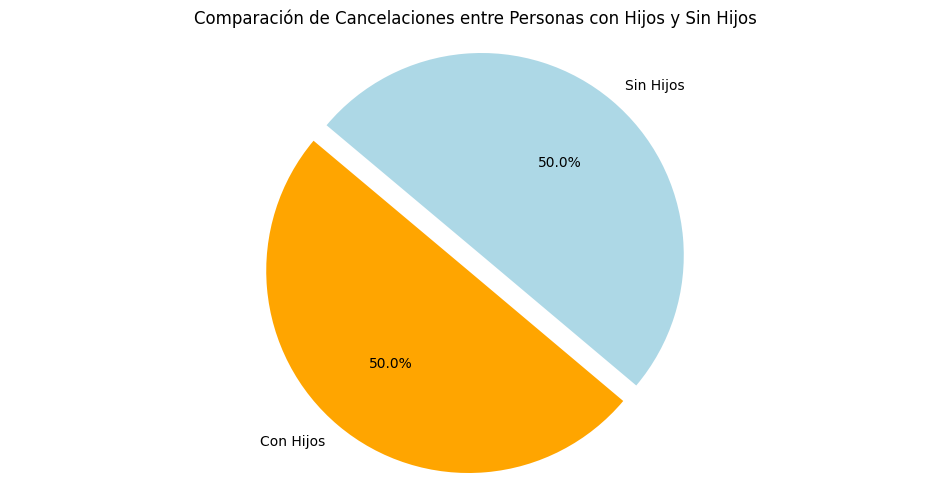

In [394]:
hotels_df['children'].fillna(0, inplace=True)

cancelations_by_children = hotels_cancelations['children'].value_counts().sort_index()
total_reservations_by_children = hotels_df['children'].value_counts().sort_index()
total_reservations_with_children = total_reservations_by_children.sum()
total_cancelations_with_children = cancelations_by_children.sum()
percentage_cancelations_with_children = (total_cancelations_with_children / total_reservations_with_children) * 100

reservations_without_children = hotels_df[hotels_df['children'] == 0]
cancelations_without_children = reservations_without_children[reservations_without_children['is_canceled'] == 1]
total_reservations_without_children = len(reservations_without_children)
total_cancelations_without_children = len(cancelations_without_children)
percentage_cancelations_without_children = (total_cancelations_without_children / total_reservations_without_children) * 100

plt.figure(figsize=(12, 6))
labels = ['Con Hijos', 'Sin Hijos']
sizes = [percentage_cancelations_with_children, percentage_cancelations_without_children]
colors = ['orange', 'lightblue']
explode = (0.1, 0)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.axis('equal') 
plt.title('Comparación de Cancelaciones entre Personas con Hijos y Sin Hijos')
plt.show()

hotels_df = hotels_df_backup

Como se puede observar, no hay una diferencia clara entre cancelar una reserva con hijos o sin hijos, por lo que no afecta al comportamiento realmente el hecho de que tengan o no tengan hijos. Esto significa que no está relacionado con el **Target** y es **irrelevante** para el entrenamiento del modelo, lo cual se condice con la Correlación de Pearson. 

#### babies

En cuanto a análisis, este parámetro resulta similar al de _children_, pero es una variable dependiente, ya que los bebes no deberían poder viajar solos nunca, si no acompañados de sus padres, y mucho menos quedarse en un hotel. En este caso es una **Variable Dependiente Cuantitativa Discreta**.

Se propone calcular las medidas de resumen:

In [395]:
# Dado que hay muchos NaN, se propone reemplazarlos con 0 para obtener las medidas de resumen, ya que si no los resultados arrojan NaN
hotels_df['babies'].fillna(0, inplace=True)

parameter_column = hotels_df['babies'].tolist()
target_column = hotels_df['is_canceled'].tolist()

media = np.mean(parameter_column)
mediana = np.median(parameter_column)
varianza = np.var(parameter_column)
desviacion_estandar = np.std(parameter_column)
moda = stats.mode(parameter_column).mode
covarianza = np.cov(parameter_column, target_column)[0, 1]
pearson = np.corrcoef(parameter_column, target_column)[0, 1]

print("Media: ", media)
print("Mediana: ", mediana)
print("Varianza: ", varianza)
print("Desviación Estandar: ", desviacion_estandar)
print("Moda: ", moda)
print("Covarianza (con respecto a Target): ", covarianza)
print("Correlación de Pearson (con respecto a Target): ", pearson)

hotels_df = hotels_df_backup

Media:  0.007155201653933746
Mediana:  0.0
Varianza:  0.008493050662499106
Desviación Estandar:  0.09215774879248682
Moda:  0
Covarianza (con respecto a Target):  -0.0014761127790147972
Correlación de Pearson (con respecto a Target):  -0.0320339665770838


Este caso es aún más evidente que el anterior, no guardan ninguna relación con la variable **Target**, se propone realizar el mismo procedimiento de comparación que antes:

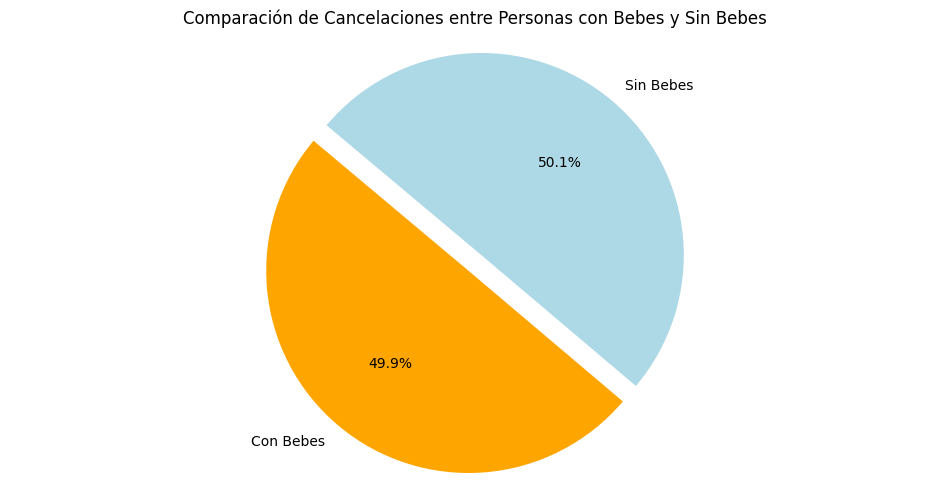

In [396]:
hotels_df['babies'].fillna(0, inplace=True)

cancelations_by_babies = hotels_cancelations['babies'].value_counts().sort_index()
total_reservations_by_babies = hotels_df['babies'].value_counts().sort_index()
total_reservations_with_babies = total_reservations_by_babies.sum()
total_cancelations_with_babies = cancelations_by_babies.sum()
percentage_cancelations_with_babies = (total_cancelations_with_babies / total_reservations_with_babies) * 100

reservations_without_babies = hotels_df[hotels_df['babies'] == 0]
cancelations_without_babies = reservations_without_babies[reservations_without_babies['is_canceled'] == 1]
total_reservations_without_babies = len(reservations_without_babies)
total_cancelations_without_babies = len(cancelations_without_babies)
percentage_cancelations_without_babies = (total_cancelations_without_babies / total_reservations_without_babies) * 100

plt.figure(figsize=(12, 6))
labels = ['Con Bebes', 'Sin Bebes']
sizes = [percentage_cancelations_with_babies, percentage_cancelations_without_babies]
colors = ['orange', 'lightblue']
explode = (0.1, 0)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.axis('equal') 
plt.title('Comparación de Cancelaciones entre Personas con Bebes y Sin Bebes')
plt.show()

hotels_df = hotels_df_backup

Como se puede observar, no hay una diferencia clara entre cancelar una reserva con bebes o sin bebes, por lo que no afecta al comportamiento realmente el hecho de que tengan o no tengan bebes. Esto significa que no está relacionado con el **Target** y es **irrelevante** para el entrenamiento del modelo, lo cual se condice con la Correlación de Pearson. 

## Visualización de los Datos

## Datos Faltantes

## Valores Atípicos

# Clasificación - Entrenamiento y Predicción